In [13]:
import torch.nn.functional as F
import pandas as pd
import numpy as np
import json
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
sns.set(rc={'figure.figsize':(11.7,8.27) ,'savefig.dpi':400})

In [14]:
with open('/content/drive/MyDrive/data/pc_data.txt') as f:
    pointcloud_data = json.load(f)

In [15]:
print(type(pointcloud_data))

<class 'dict'>


In [16]:
dict_items = pointcloud_data.items()

first_two = list(dict_items)[:2]
print(first_two)

[('662471380a6648758dbe7b12b5704245', {'pointcloud': [[[-4.265641689300537, -7.040708541870117, -1.9505250453948975], [-4.303304195404053, -7.008563995361328, -1.9486749172210693], [-4.778904438018799, -7.777182579040527, -1.9402260780334473], [-4.32615852355957, -6.955582141876221, -1.9408366680145264], [-4.813284397125244, -7.732829570770264, -1.9360610246658325], [-5.460909843444824, -8.766571044921875, -1.9459418058395386], [-4.352650165557861, -6.90912389755249, -1.9348406791687012], [-4.850451469421387, -7.6934709548950195, -1.9331557750701904], [-5.506091117858887, -8.726628303527832, -1.9440877437591553], [-4.385037899017334, -6.872508525848389, -1.9316167831420898], [-4.884160041809082, -7.648825168609619, -1.9289907217025757], [-5.549912452697754, -8.684784889221191, -1.9418621063232422], [-6.451568126678467, -10.189674377441406, -1.9814280271530151], [-5.8091959953308105, -9.153746604919434, -0.7580974698066711], [-4.412899971008301, -6.829116344451904, -1.9265414476394653],

In [17]:
#create X and y from json 
X = []
y = []
for x in pointcloud_data:
  X.append(pointcloud_data[x]['pointcloud'])
  y.append(pointcloud_data[x]['category'])


In [18]:
#check the length of X and y to ensure proper unpacking of json file 
print(len(X), len(y))

1781 1781


In [19]:
#unnest pointcloud arrays

X = [item for sublist in X for item in sublist]

In [20]:

#find max length of point cloud vectors 
def FindMinMaxLength(x,min_size,max_size):
  max_length = min_size
  min_length = max_size
  for a in range(len(x)):
    if len(x[a]) > max_length:
      max_length = len(x[a])
      max_a = a
    elif len(x[a]) < min_length:
      min_length = len(x[a])
      min_a = a
  print ("Maximum Point Cloud Vector is " + str(max_length) +" and is labelled: "+
         str(y[max_a])+"\nMinimum Point Cloud Vector is " + str(min_length) + 
         " and is labelled :" + str(y[min_a]))

In [21]:
FindMinMaxLength(X,0,1000)

Maximum Point Cloud Vector is 1667 and is labelled: ['vehicle_construction']
Minimum Point Cloud Vector is 21 and is labelled :['vehicle_car']


In [22]:
#Function to save point cloud size as list 

def CalculateSize(x):
  Sizes = []
  for a in range(len(x)):
    Sizes.append(len(x[a]))
  return Sizes
    


In [23]:
#create list of vector sizes
VectorSizes = CalculateSize(X)

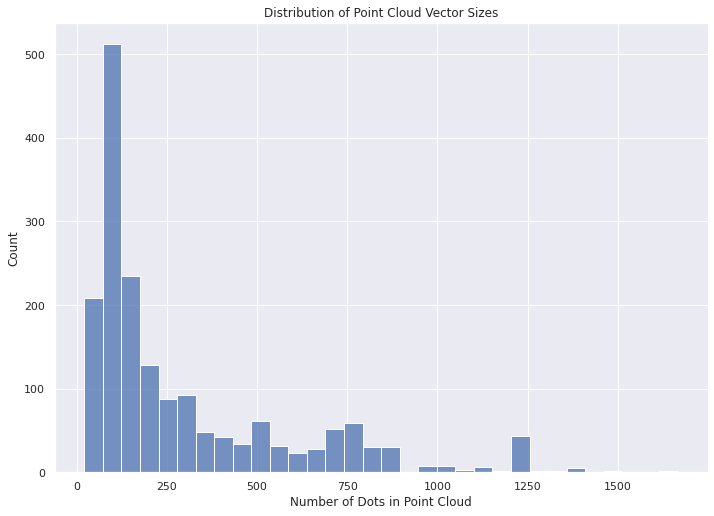

In [24]:
#plot histogram of vector sizes 
sns.histplot(VectorSizes).set(title="Distribution of Point Cloud Vector Sizes")
plt.xlabel("Number of Dots in Point Cloud")
plt.savefig("Vector_Size.png")

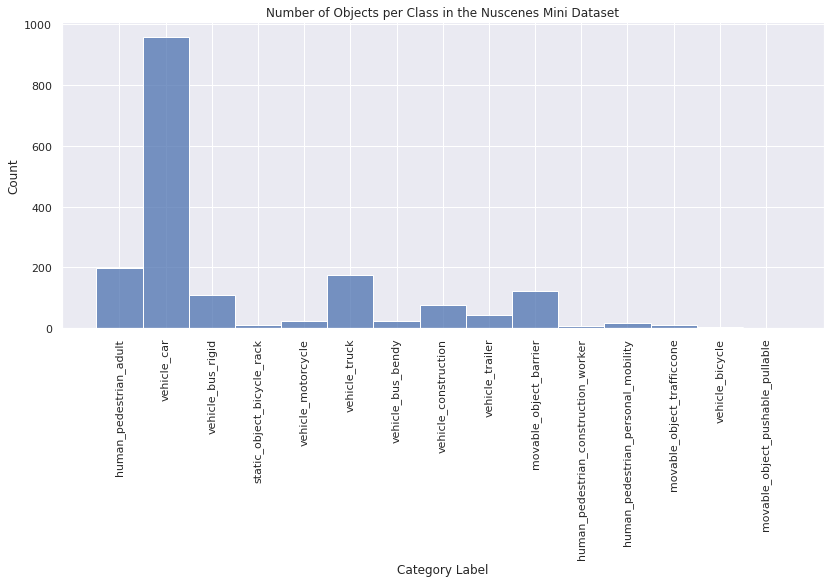

In [25]:
#visualize class distribution


merged_labels = list(itertools.chain(*y))
sns.histplot(merged_labels).set(title="Number of Objects per Class in the Nuscenes Mini Dataset")
plt.xticks(rotation=90)
plt.xlabel("Category Label")
plt.tight_layout()
plt.savefig("Category_Count.png")

In [26]:
#create df of class with vector size

ClassSize = pd.DataFrame(list(zip(merged_labels,VectorSizes)), columns =['Category', 'Size'])


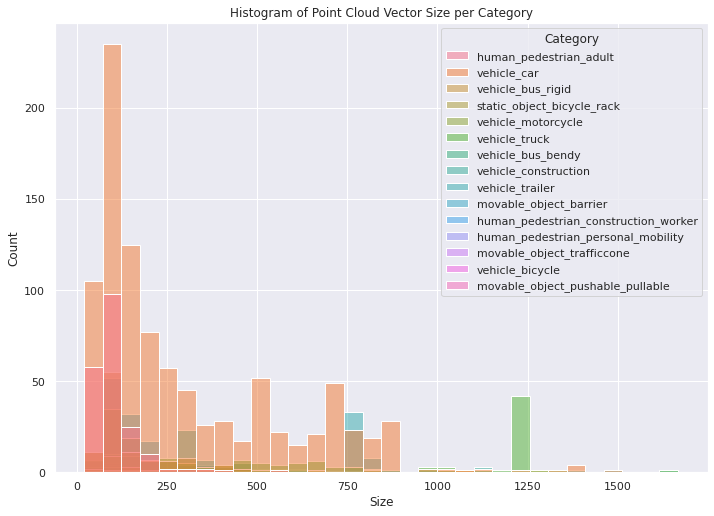

In [27]:
#plot histogram of cloud sizes by category label
sns.histplot(data=ClassSize, x="Size", hue="Category").set(title="Histogram of Point Cloud Vector Size per Category")
plt.savefig("Category_Size.png")

In [28]:
#function reshape vectors to x,y,z arrays 

def ReshapeVectors(x):
  for a in range(len(x)):
    dots = len(X[a])
    x[a] = np.asarray(x[a])
    x[a]  = np.transpose((x[a]))


In [29]:
    #reshape vectors 
    ReshapeVectors(X)

In [30]:
#function to pad vectors to equal length 

def PadClouds(x, length):
  for a in range(len(x)):
    x[a] = pad_sequences(
    x[a], maxlen=length, dtype='float64', padding='pre',
    truncating='pre', value=0.0) 



In [31]:
#pad vectors to 844 as the average length that will preserve most vectors

PadClouds(X,844)

In [32]:
#function to check length of padded vectors and ensure same length 

def FindMinMaxLengthDos(x):
  max_length = 0
  min_length = 845
  for a in range(len(x)):
      if len(x[a][0]) > max_length:
        max_length = len(x[a][0])
        max_a = a
      elif len(x[a][0]) < min_length:
        min_length = len(x[a][0])
        min_a = a
  print ("Maximum Cloud Point Vector is " + str(max_length) +" and is labelled: "+
         str(y[max_a])+"\nMinimum Cloud Point Vector is " + str(min_length) + 
         " and is labelled :" + str(y[min_a]))

In [33]:
#check for equal length in all vectors

FindMinMaxLengthDos(X)

Maximum Cloud Point Vector is 844 and is labelled: ['human_pedestrian_adult']
Minimum Cloud Point Vector is 844 and is labelled :['vehicle_car']


In [34]:
#Function Normalize point cloud values

def NormalizePointClouds(x):
  for a in range(len(x)):
    for b in range(len(x[a])):
      norm = np.linalg.norm(x[a][b])
      x[a][b] = x[a][b]/norm

In [35]:
#Normalize point cloud values for modeling
NormalizePointClouds(X)

In [36]:
#reshape vectors back to [x,y,z] values for each point 

ReshapeVectors(X)

In [37]:
#unnest list of category labels 
y_list = [item for sublist in y for item in sublist]

In [38]:

#encode all y labels to int for modelling
LE = LabelEncoder()
y_encoded = LE.fit_transform(y_list)

#create dictionary of encoded labels
le_name_mapping = dict(zip(LE.classes_, LE.transform(LE.classes_)))

#reverse key and value
le_map = {v: k for k, v in le_name_mapping.items()}

#print encode keys 
print(le_map)


{0: 'human_pedestrian_adult', 1: 'human_pedestrian_construction_worker', 2: 'human_pedestrian_personal_mobility', 3: 'movable_object_barrier', 4: 'movable_object_pushable_pullable', 5: 'movable_object_trafficcone', 6: 'static_object_bicycle_rack', 7: 'vehicle_bicycle', 8: 'vehicle_bus_bendy', 9: 'vehicle_bus_rigid', 10: 'vehicle_car', 11: 'vehicle_construction', 12: 'vehicle_motorcycle', 13: 'vehicle_trailer', 14: 'vehicle_truck'}


In [39]:
#keep only "vehicle_car" class for binary classification

y_encoded[y_encoded != 10] = 0
y_encoded[y_encoded == 10] = 1

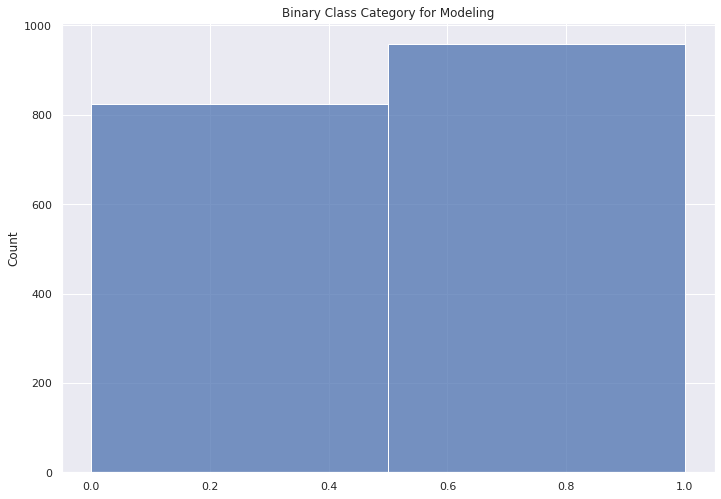

In [40]:
#visualize class distribution


sns.histplot(y_encoded, binwidth=0.5).set(title="Binary Class Category for Modeling")
plt.savefig("Binary_Hist.png")


In [41]:
#split data into train and test 

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.33, random_state=33)


In [42]:
#augment cloud point vectors by jittering and randomizing 

BATCH_SIZE = 32
NUM_CLASSES = 2
NUM_POINTS = 844

def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(len(X_train)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(X_test)).batch(BATCH_SIZE)

In [43]:
#create convolutional layers
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

#create dense layers
def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [44]:
#create orthogonal class
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [45]:
#create function to initialize tnet
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [46]:
#initiate model
inputs = keras.Input(shape=(NUM_POINTS,3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")

#get model summary
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 844, 3)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 844, 32)      128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 844, 32)     128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 844, 32)      0           ['batch_normalization[0][0

In [48]:
#compile model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"]
)

# create patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

#train and fit model on data
PointNet = model.fit(train_dataset, epochs=200, validation_data=test_dataset, callbacks=[es])

Epoch 1/200
38/38 [==============================] - 61s 1s/step - loss: 1.6687 - sparse_categorical_accuracy: 0.7024 - val_loss: 5.3467 - val_sparse_categorical_accuracy: 0.6207
Epoch 2/200
38/38 [==============================] - 55s 1s/step - loss: 1.6367 - sparse_categorical_accuracy: 0.7318 - val_loss: 23613.5996 - val_sparse_categorical_accuracy: 0.6752
Epoch 3/200
38/38 [==============================] - 55s 1s/step - loss: 1.6389 - sparse_categorical_accuracy: 0.7578 - val_loss: 23.8776 - val_sparse_categorical_accuracy: 0.6514
Epoch 4/200
38/38 [==============================] - 55s 1s/step - loss: 1.5969 - sparse_categorical_accuracy: 0.7594 - val_loss: 18.2226 - val_sparse_categorical_accuracy: 0.7415
Epoch 5/200
38/38 [==============================] - 55s 1s/step - loss: 1.6065 - sparse_categorical_accuracy: 0.7460 - val_loss: 1.9935 - val_sparse_categorical_accuracy: 0.6871
Epoch 6/200
38/38 [==============================] - 55s 1s/step - loss: 1.5938 - sparse_categorica

In [49]:
#create map of category labels 
bin_map = {0: 'Noise', 1:'Car'}

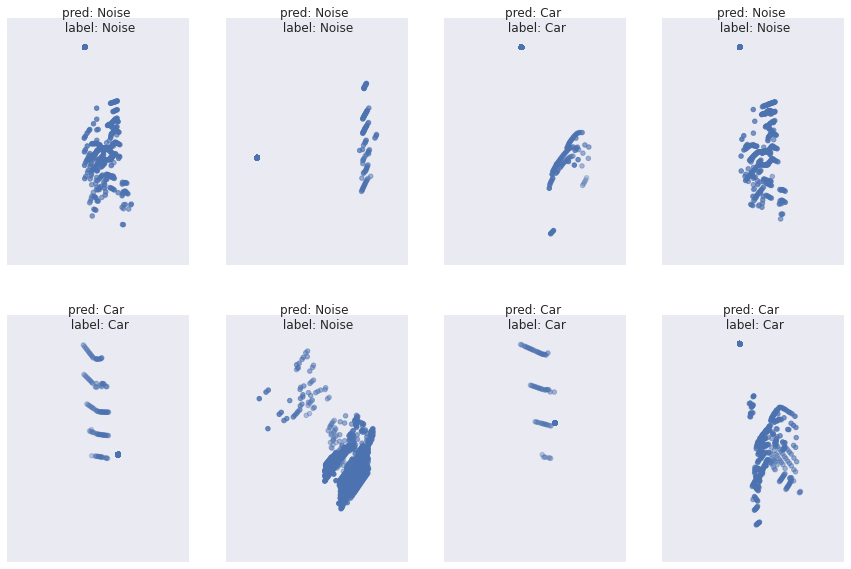

In [50]:
#visualize prediction and actual label for point cloud vectors 
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:} \n label: {:}".format(
            bin_map[preds[i].numpy()], bin_map[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

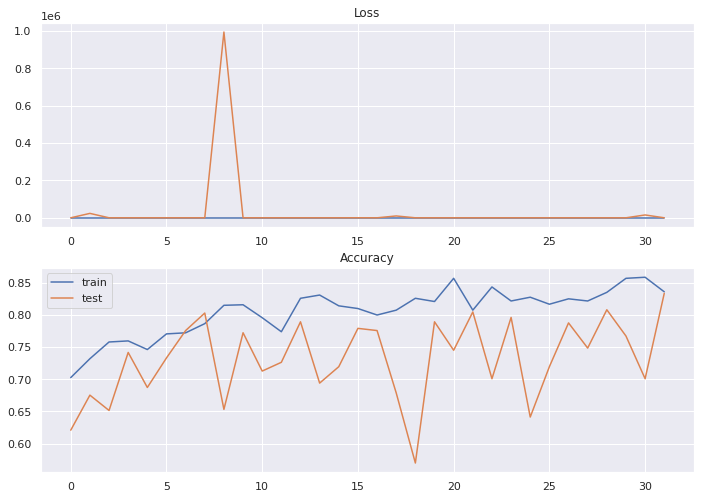

In [51]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(PointNet.history['loss'], label='train')
plt.plot(PointNet.history['val_loss'], label='test')

# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(PointNet.history['sparse_categorical_accuracy'], label='train')
plt.plot(PointNet.history['val_sparse_categorical_accuracy'], label='test')
plt.legend()
plt.savefig("loss_accuracy.png")
plt.show()
